In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
import cv2
import imghdr

# Data Cleaning

In [6]:
data_dir = 'data' #dataset file
image_exts = ['jpeg','jpg', 'bmp', 'png'] # accepted image types


In [7]:
image_exts 

['jpeg', 'jpg', 'bmp', 'png']

In [8]:
os.listdir(data_dir)

['car', 'human']

In [10]:
# os.listdir(os.path.join(data_dir, 'car'))

In [11]:
for image_class in os.listdir(data_dir):
    print(image_class)

car
human


In [12]:
# Remove corrupted and unsuitable images
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

Image not in ext list data\human\family-6.jpg
Image not in ext list data\human\Morocco_team.jpg
Image not in ext list data\human\us-ar.jpg
Image not in ext list data\human\World-s-top-10-billionaires.jpg


In [20]:
# Let's chek how many images we have now in each file
# List the subdirectories in the data directory
subdirectories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Loop through each subdirectory and count the number of images
for subdir in subdirectories:
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path):
        image_count = sum(1 for file in os.listdir(subdir_path) if file.lower().endswith(tuple(image_exts)))
        print(f"The '{subdir}' folder contains: {image_count} images.")

The 'car' folder contains: 550 images.
The 'human' folder contains: 550 images.


Perfect! we have an equal amount of clean image data between our cars and humans folders.

In [21]:
# Let's display a picture
pic = cv2.imread(os.path.join('data','human', '14physed-running-photo-superJumbo.jpg')) 

In [22]:
pic.shape # ((1288 high, 2048 wide, 3 = colored))

(1288, 2048, 3)

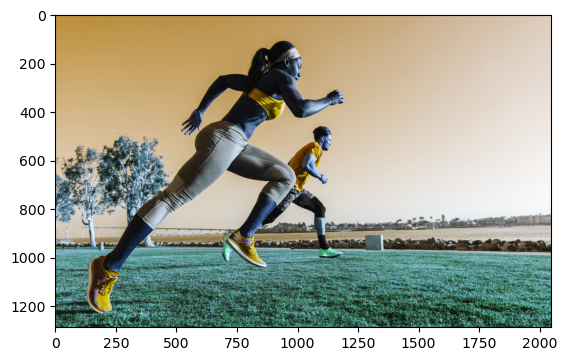

In [23]:
plt.imshow(pic)
plt.show()

# Loading and Processing Data

In [176]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1100 files belonging to 2 classes.


In [195]:
data_iterator = data.as_numpy_iterator()

In [196]:
batch = data_iterator.next()

In [197]:
batch[1]

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0])

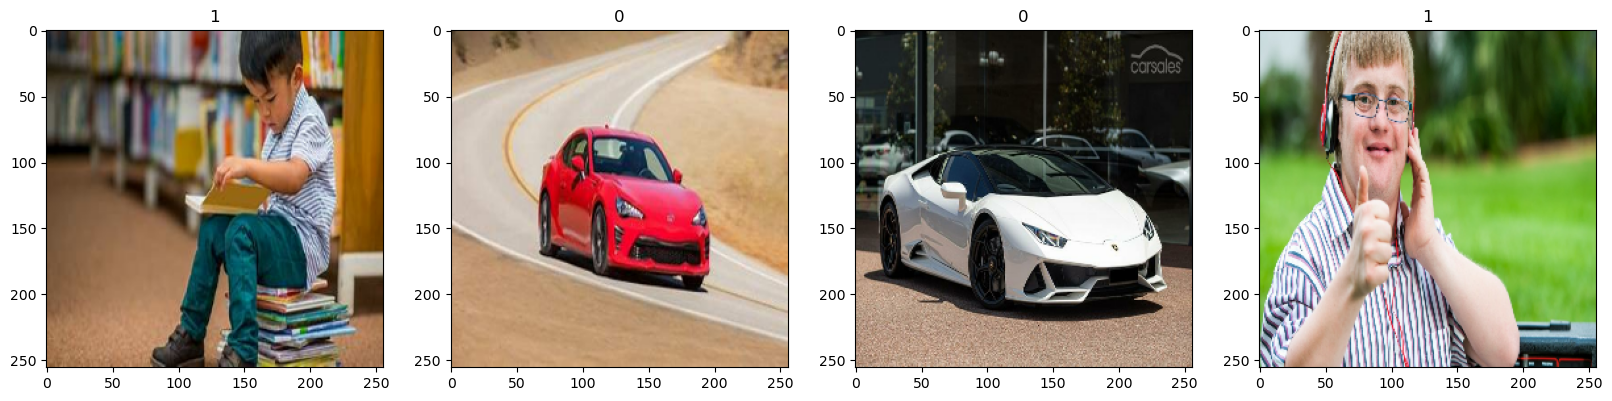

In [198]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx]) # So class 1 = human & class 0 = car

In [83]:
#Data Scaling 
data = data.map(lambda x,y: (x/255, y))

In [84]:
data.as_numpy_iterator().next()

(array([[[[1.        , 0.98961395, 0.6994179 ],
          [0.99618566, 0.9728707 , 0.67504597],
          [0.99459255, 0.97106314, 0.6730239 ],
          ...,
          [0.44462317, 0.5387408 , 0.7112898 ],
          [0.45108762, 0.5452053 , 0.7177543 ],
          [0.45755208, 0.5516697 , 0.7242187 ]],
 
         [[0.99899673, 0.982422  , 0.69222593],
          [0.9870718 , 0.96358764, 0.66576284],
          [0.9853094 , 0.96178   , 0.6637408 ],
          ...,
          [0.4415288 , 0.53564644, 0.70819545],
          [0.44799325, 0.5421109 , 0.7146599 ],
          [0.45445773, 0.54857534, 0.7211244 ]],
 
         [[0.99453676, 0.9728707 , 0.68267465],
          [0.97700673, 0.9534773 , 0.6556526 ],
          [0.977742  , 0.9542126 , 0.6561734 ],
          ...,
          [0.4381587 , 0.53227633, 0.70482534],
          [0.44462317, 0.5387408 , 0.7112898 ],
          [0.4493692 , 0.54348683, 0.71603584]],
 
         ...,
 
         [[0.568208  , 0.3564433 , 0.25723985],
          [0.58067

In [86]:
# Spliting data
train_size = int(len(data)*.7) # train data
val_size = int(len(data)*.2) # validation data
test_size = int(len(data)*.1) # testing data

In [87]:
len(data)

35

In [88]:
train_size + val_size + test_size # =35 = len(data)-1 because 35 is an odd number

34

In [90]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size) 

In [91]:
len(train) # training takes 24 batches

24

# Deep Learning

In [92]:
#Building a Deep Learning model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [93]:
model = Sequential() # The Sequential class is a linear stack of layers for building a neural network model layer by layer.

In [94]:
# Building the neural network
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [95]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [96]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [97]:
logdir='logs' # directory where log files for training and evaluation get stored. 

In [98]:
# Training
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [99]:
# Fitting
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
24/24 [==============================] - 67s 3s/step - loss: 0.6530 - accuracy: 0.6484 - val_loss: 0.3556 - val_accuracy: 0.8080
Epoch 2/20
24/24 [==============================] - 74s 3s/step - loss: 0.3190 - accuracy: 0.8659 - val_loss: 0.3862 - val_accuracy: 0.8259
Epoch 3/20
24/24 [==============================] - 92s 4s/step - loss: 0.1691 - accuracy: 0.9440 - val_loss: 0.1117 - val_accuracy: 0.9554
Epoch 4/20
24/24 [==============================] - 65s 3s/step - loss: 0.1326 - accuracy: 0.9583 - val_loss: 0.1405 - val_accuracy: 0.9554
Epoch 5/20
24/24 [==============================] - 61s 2s/step - loss: 0.0899 - accuracy: 0.9701 - val_loss: 0.1206 - val_accuracy: 0.9643
Epoch 6/20
24/24 [==============================] - 65s 3s/step - loss: 0.0476 - accuracy: 0.9870 - val_loss: 0.1070 - val_accuracy: 0.9598
Epoch 7/20
24/24 [==============================] - 62s 2s/step - loss: 0.0276 - accuracy: 0.9922 - val_loss: 0.0664 - val_accuracy: 0.9732
Epoch 8/20
24/24 [==

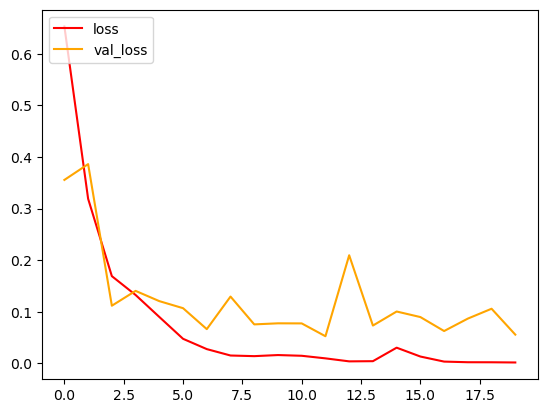

In [100]:
# Plot Performance
# Loss
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

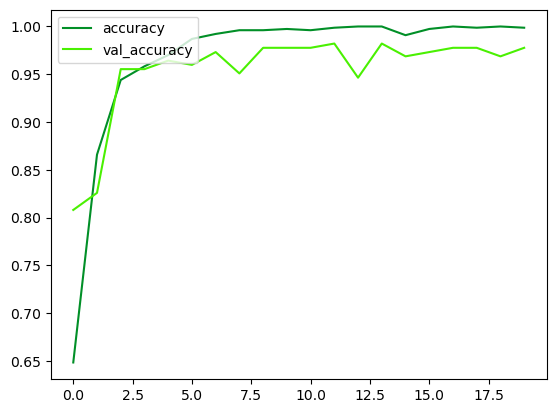

In [101]:
# Accuracy
plt.plot(hist.history['accuracy'], color='#018f27', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='#4af002', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate the Performance

In [103]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [104]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 381ms/step


In [105]:
print(f"""Precission: {pre.result()}
Recall: {re.result()}
Accuracy: {acc.result()}""")

Precission: 0.9599999785423279
Recall: 0.9795918464660645
Accuracy: 0.96875


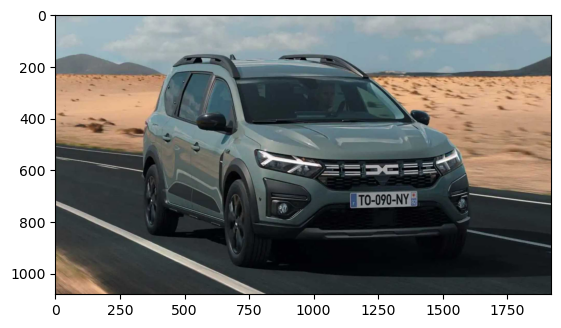

In [106]:
# So our model did really well with our testing data
# But let's also try our model on images from the internet that were not part of our data
img = cv2.imread('test-images/dacia.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

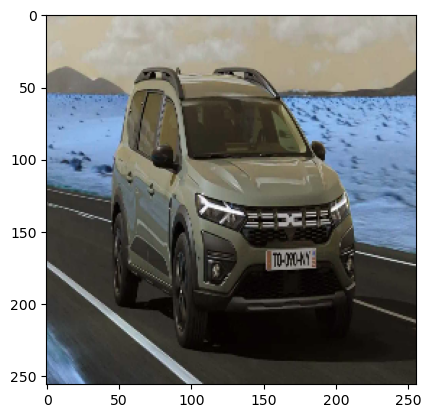

In [107]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [108]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 299ms/step


In [109]:
yhat

array([[1.6433714e-05]], dtype=float32)

In [110]:
if yhat > 0.5: 
    print(f'Predicted class is human')
else:
    print(f'Predicted class is car')

Predicted class is car


In [111]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 525ms/step


In [112]:
print(f"""Precission: {pre.result()}
Recall: {re.result()}
Accuracy: {acc.result()}""")

Precission: 0.9626168012619019
Recall: 0.9716981053352356
Accuracy: 0.9635416865348816


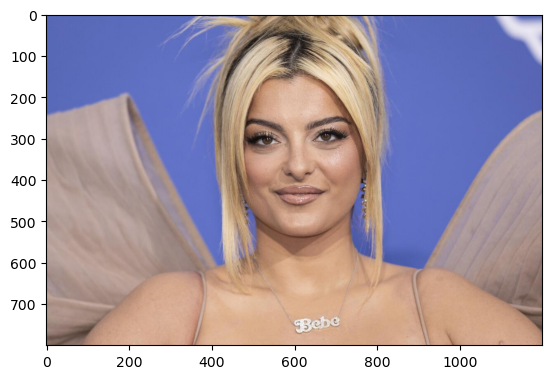

In [123]:
# Now let's try a photo of the singer Bebe Rexha knowing our model has not seen her before
img = cv2.imread('test-images/singer.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

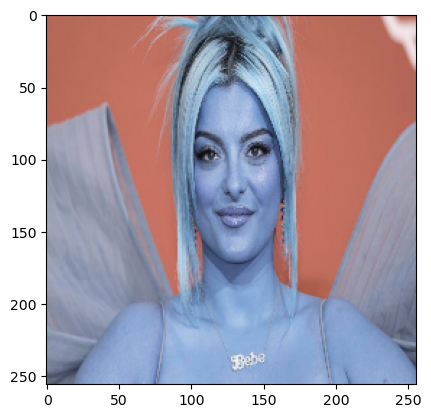

In [124]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [125]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 33ms/step


In [126]:
yhat

array([[0.98204774]], dtype=float32)

In [127]:
if yhat > 0.5: 
    print(f'Predicted class is human')
else:
    print(f'Predicted class is car')

Predicted class is human


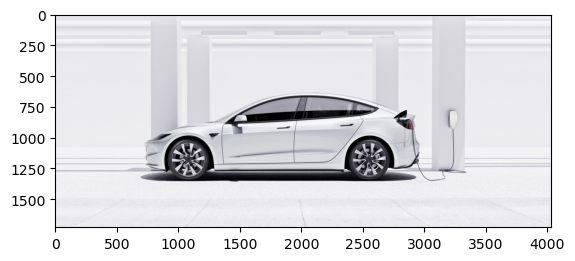

In [171]:
# 3rd try: Let's see if the model will recognize the nature of this electric truck
img = cv2.imread('test-images/tesla.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

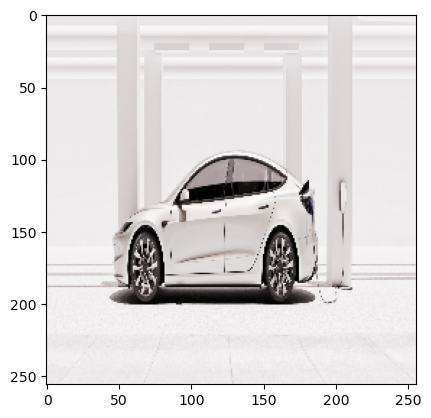

In [172]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [173]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 47ms/step


In [174]:
print(yhat)

[[3.721244e-12]]


In [175]:
if yhat > 0.5: 
    print(f'Predicted class is human')
else:
    print(f'Predicted class is car')

Predicted class is car


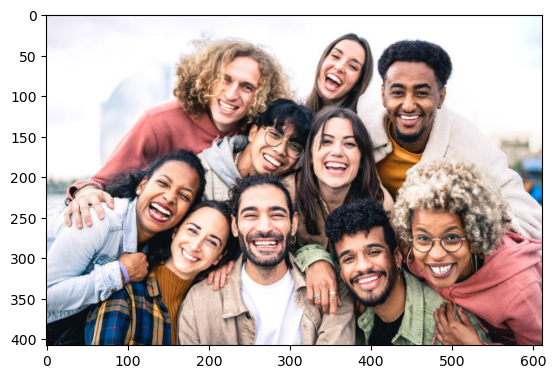

In [148]:
# 4th try: Let's try the model with a group of people
img = cv2.imread('test-images/group.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

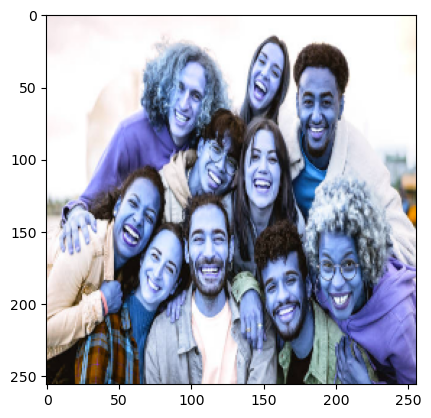

In [149]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [151]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 32ms/step


In [152]:
print(yhat)

[[0.99999577]]


In [153]:
if yhat > 0.5: 
    print(f'Predicted class is human')
else:
    print(f'Predicted class is car')

Predicted class is human
